In [1]:
import numpy as np
import GPy
import datetime
import matplotlib.pyplot
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import csv
import pickle
from epics import caget, caput
from scipy.interpolate import LinearNDInterpolator
import time

import CBOopt

In [2]:
def set_act(mots, motpos, timeout = 60):
    for i, mot in enumerate(mots):
        caput(mot + ':MOT.VAL', motpos[i])
    time.sleep(0.1)
    mov = True
    while mov:
        status = 0
        for mot in mots:
            status = status + (caget(mot + ':MOT.DMOV') - 1)
        mov = bool(status)
        time.sleep(0.1)
        timeout -= 0.1
        if timeout <= 0:
            print('TIMEOUT:   ({} s) while moving motors'.format(timeout))
            return False
    return True
        
def get_motpos(mots):
    motpos = []
    for mot in mots:
        motpos.append(caget(mot + ':MOT.RBV'))
    return motpos

# Send motor position and get integrate camera value
def cost(points):
    mots = ['TWLHA-LMOT-MW33', 'TWLHA-LMOT-MW34']
    set_act(mots, np.squeeze(points))
    # time.sleep(5)
    # avg = 100
    val = (caget('TWLHA-LCAM-C101:INTEGRAL_AVE') - 3.5E5) / 6E6
    y_new = np.array([val])
    # val = val[-avg:]
    # print(val[-50:])
    # print(np.mean(val), np.std(val))
    # y_new = np.array([np.mean(val)])
    # plt.plot(val)
    return -y_new

In [3]:
pp = np.array([4755, 8797])
cost(pp)

CA.Client.Exception...............................................
    Context: "Channel: "TWLHA-LCAM-C101:INTEGRAL_AVE", Connecting to: 172.21.11.146:5064, Ignored: pc14973:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Fri Mar 11 2022 14:19:18.410027844
..................................................................


array([-0.67113133])

CA.Client.Exception...............................................
    Context: "Channel: "TWLHA-LCAM-C101:INTEGRAL_AVE", Connecting to: 172.21.11.146:5064, Ignored: pc14973:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Fri Mar 11 2022 14:19:18.411290759
..................................................................


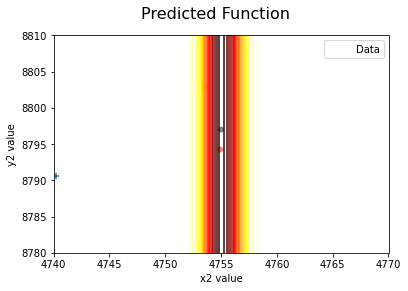

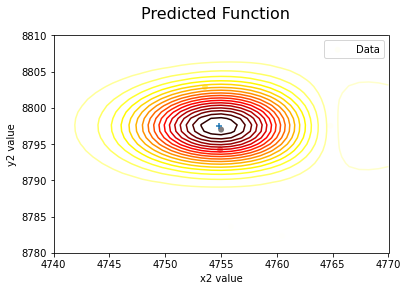

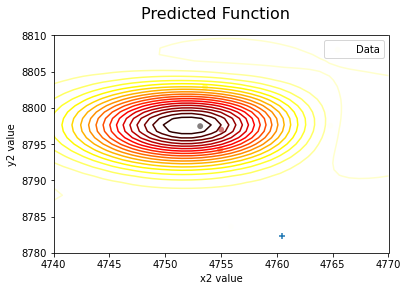

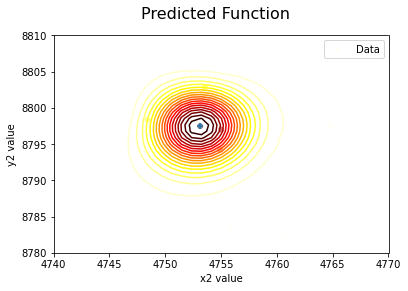

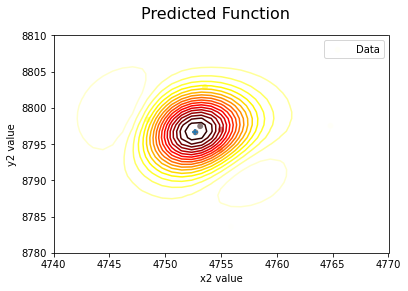

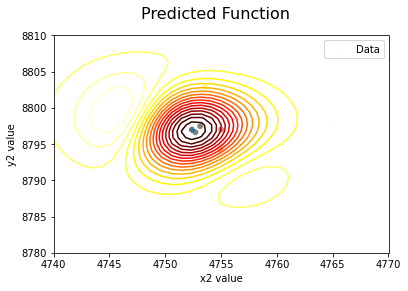

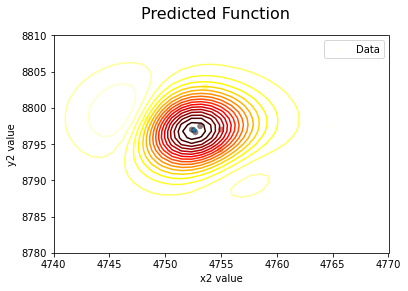

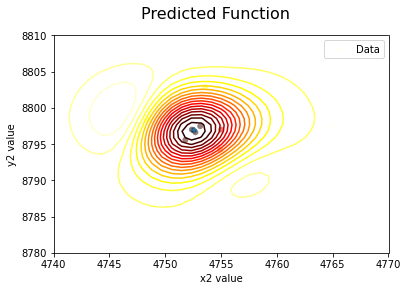

In [10]:
Data = []
n_init = 5
Axis_select = "x"
iterlim = 100
stop_eic_abs = 0.001
optimization_method = "PSO"
update_hyperparameters_flag = True
std_limit = 0.1
PSO_den = 100
lengthscale = [2, 2]
variance = [0.1]

# Save plots to folder
# directory = 'CBO_Results_new/'
# Bayesian optimization parameters

dim_x = 2  # optimizazion dimension
beta = 3  # confidence parameter (default = 3 ~99% confidence)
d_min = np.array([4740, 8780])   # domain lower bound
d_max = np.array([4770, 8810])  # domain upper bound
discretization = np.array([0.01, 0.01])
# NOTE (CK): Try smaller safe domain
d_min_safe = np.array([4740, 8780]) 
d_max_safe = np.array([4770, 8810])
constrlim = np.array([None])  # constraint limit (if the cost itself is not constrained use None)
init = CBOopt.LHCsample(n_init, dim_x, d_min_safe, d_max_safe) # random samples
init_0 = np.array([[4755, 8797]]) 
init = np.append(init, init_0, axis = 0)
filename = "CBOoptimization"
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M')  # Time stamp for data storage
safe_flag = False

# Evaluate initial set
samples = init.copy()
val = cost(np.expand_dims(samples[0, 0:dim_x], axis=0))
values = np.array([val])

for i in range(1, samples.shape[0]):
    val = cost(np.expand_dims(samples[i], axis=0))
    values = np.vstack((values, val))
    
# GP kernel
RBF = GPy.kern.RBF(input_dim=dim_x, ARD=True, lengthscale=lengthscale, variance=variance)  
# cost GP
gp0 = GPy.core.GP(samples, values, RBF, GPy.likelihoods.Gaussian(variance=0.015))
# Save GP(s) in list, gps[0] = cost function
gps = [gp0]

opt = CBOopt.CBOopt(gps, constrlim, d_min, d_max, stop_eic_abs=stop_eic_abs)
if update_hyperparameters_flag is True:
    opt.update_hyperparameters()
i = 0  # current iteration

opt.calculate_grid(discretization) 
xy_sample = opt.grid.copy()

while i < iterlim and opt.stopcount < 3:

    # Plot next point to evaluate
    EIC_t = opt.EIC(xy_sample)
    i_next = np.argmax(EIC_t)

    # Calculate optimizer
    if optimization_method == "PSO":
        x_opt, eic = opt.get_optimizer_PSO(PSO_den * dim_x)
    elif optimization_method == "grid evaluation":
        x_opt, eic = opt.get_optimizer_grideval(discretization)
    else:
        print("undefined optimization method: ", optimization_method)
        raise ()

    # Evaluate optimizer
    cord = np.array([[x_opt[0], x_opt[1]]])
    val = cost(cord)
    y = np.array([[val]])
    opt.add_new_data_point(x_opt, y[0])
    if update_hyperparameters_flag is True:
        opt.update_hyperparameters()
    # Best prediction
    x_opt, x_opt_mean, x_opt_std = opt.get_best_prediction(-1, constraint=lambda x: opt.get_posterior(x,0)[1] < std_limit, safe_set=opt.x)

    # Plot best prediction
    fig1, ax1 = matplotlib.pyplot.subplots()
    plt1 = opt.gps[0].plot(plot_limits=[[d_min[0], d_min[1]], [d_max[0], d_max[1]]], ax=ax1)
    ax1.scatter(x_opt[0], x_opt[1], marker="+")
    ax1.set_xlim([d_min[0], d_max[0]])
    ax1.set_ylim([d_min[1], d_max[1]])
    fig1.suptitle('Predicted Function', fontsize=16)
    ax1.set_xlabel('x2 value')
    ax1.set_ylabel('y2 value')
    
    i = i + 1
    
#file_title_fig1 = "Prediction_Plot_Optimization{}".format(i+ 1)



In [5]:
init_0 = np.array([[10, 10]])
A = np.append(init, init_0, axis = 0)
A

array([[4756.13567115, 8786.01510344],
       [4763.36039731, 8807.90110712],
       [4769.8072489 , 8785.98646572],
       [4751.04850157, 8801.69827515],
       [4741.57482093, 8795.71216649],
       [4755.        , 8797.        ],
       [  10.        ,   10.        ]])

In [9]:
[[d_min[0], d_max[0]], [d_min[1], d_max[1]]]

[[4740, 4770], [8780, 8810]]